## Read the dataset

In [1]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
sns.set(style="whitegrid", font_scale=1)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv('train.csv')
dfTest = pd.read_csv('test.csv')
cateColList = df.select_dtypes(include=['object']).columns
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Data cleaning

Find out which columns are numerical and categorical.


In [3]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [4]:
def get_nulls_percentage(df):
    dict_nulls = {}
    for col in  df.columns:
        percentage_null_values = str(round(df[col].isnull().sum()/len(df),5))+"%"
        dict_nulls[col] = percentage_null_values
    df_nulls = pd.DataFrame(data=list(dict_nulls.values()), 
                            index=list(dict_nulls.keys()), 
                            columns=['% nulls'])
    return df_nulls
    
get_nulls_percentage(df)

,% nulls
PassengerId,0.0%
HomePlanet,0.02312%
CryoSleep,0.02496%
Cabin,0.02289%
Destination,0.02094%
Age,0.02059%
VIP,0.02335%
RoomService,0.02082%
FoodCourt,0.02105%
ShoppingMall,0.02393%


The percentages of missing values in each column is very small, so the possible solutions are:
* For numerical column: replace the missing by the avarage value.
* For categorical columns: replace the missing by the mode of all values.
* Note that: for the name column, just drop the record which contains the missing value.

In [5]:
# fill the missing values
def fillMissing(df):
    for col in df:
        if col!="Name":
            if df[col].dtype != object:
                if col == "Age":
                    df[col] = df[col].fillna(df[col].median())
                elif col == "VIP" or col == "CryoSleep":
                    df[col] = df[col].fillna(False)
                else:
                    # print(col)
                    df[col] = df[col].fillna(df[col].mean())
            else:
                L = len(df[col].mode())
                df[col] = df[col].fillna(df[col].mode()[random.randrange(L)])
    return df
df = fillMissing(df)
dfTest = fillMissing(dfTest)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
# check the percentage of missing value after filled
get_nulls_percentage(df)

,% nulls
PassengerId,0.0%
HomePlanet,0.0%
CryoSleep,0.0%
Cabin,0.0%
Destination,0.0%
Age,0.0%
VIP,0.0%
RoomService,0.0%
FoodCourt,0.0%
ShoppingMall,0.0%


## Data exploring and visualization

First, take a look at correlation. The best is belong to CryoSleep.

In [7]:
df.corr()["Transported"].sort_values()

/var/folders/sf/b5m722pn4qv2v5d85y472fqh0000gn/T/ipykernel_13781/3554268114.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()["Transported"].sort_values()


RoomService    -0.242048
Spa            -0.218791
VRDeck         -0.204825
Age            -0.074233
VIP            -0.037261
ShoppingMall    0.010019
FoodCourt       0.046074
CryoSleep       0.460132
Transported     1.000000
Name: Transported, dtype: float64

Some figures to have an overview:

<AxesSubplot: xlabel='Transported', ylabel='count'>

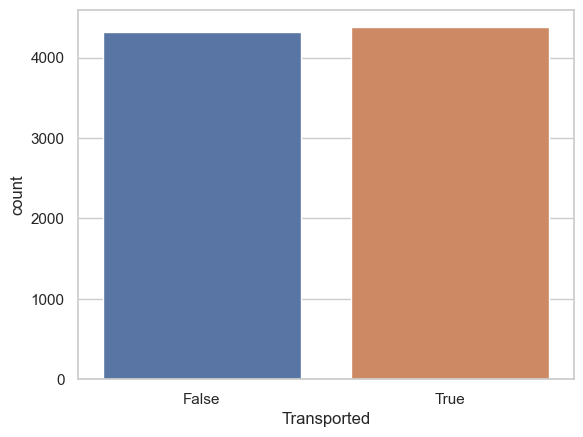

In [8]:
sns.countplot(x=df["Transported"])

<AxesSubplot: xlabel='CryoSleep', ylabel='count'>

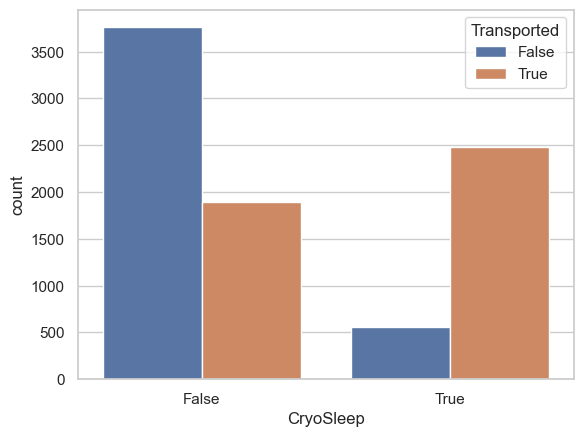

In [9]:
sns.countplot(x=df["CryoSleep"], hue=df["Transported"])

<AxesSubplot: xlabel='VIP', ylabel='count'>

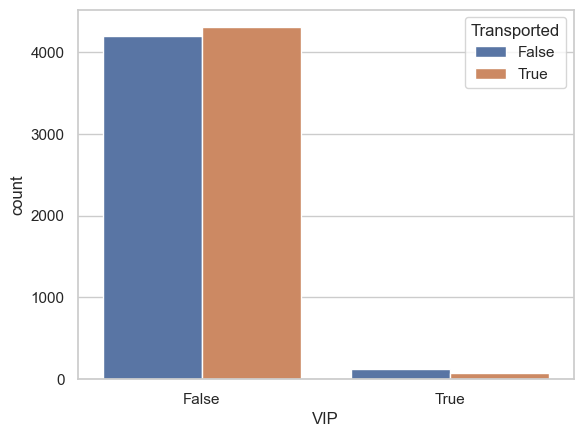

In [10]:
sns.countplot(x=df["VIP"], hue=df["Transported"])

<AxesSubplot: xlabel='Transported', ylabel='Age'>

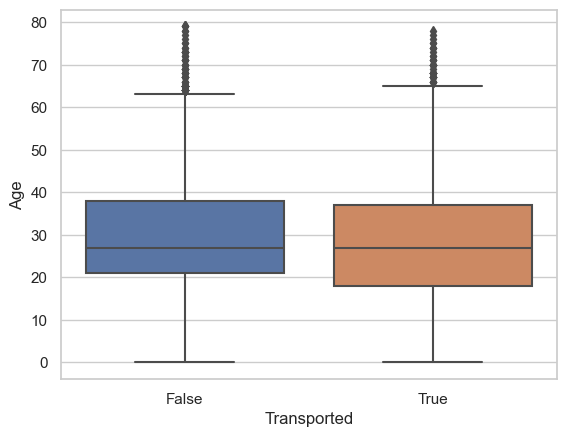

In [11]:
sns.boxplot(x=df["Transported"], y = df["Age"])

<AxesSubplot: xlabel='Transported', ylabel='FoodCourt'>

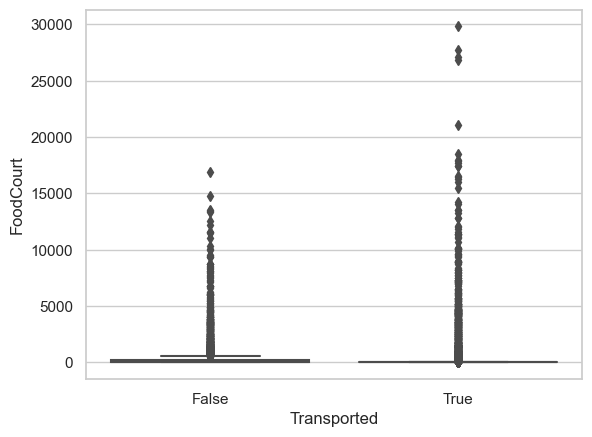

In [12]:
sns.boxplot(x=df["Transported"], y = df["FoodCourt"])

## Feature engineering

In [14]:
def addAgeGroup(df):
    df["AgeGroup"] = 0
    for i in range(6):
        df.loc[(df.Age >= 10*i) & (df.Age < 10*(i+1)), "AgeGroup"] = i
    return df
def addNetSpent(df):
    res = df.assign(NetSpent = lambda x: (x["RoomService"]+x["FoodCourt"]+x["ShoppingMall"]+x["Spa"]+x["VRDeck"]))
    return res
def labelCategorical(df, df2):
    for col in cateColList:
        if col!="Cabin" and col!="Name" and col!="PassengerId":
            tmp = np.concatenate((df[col], df2[col])).astype(str)
            LE = LabelEncoder()
            print(col)
            LE.fit(tmp)
            df[col]=LE.transform(df[col].astype(str))
            df2[col]=LE.transform(df2[col].astype(str))
    return df, df2

df[['Deck','Num','Side']] = df.Cabin.str.split('/',expand=True) 
dfTest[['Deck','Num','Side']] = dfTest.Cabin.str.split('/',expand=True)
# cateColList = cateColList.insert(-1, ['Deck','Num','Side'])
print(cateColList)

tmp1, tmp2 = labelCategorical(df.drop(["Name", "Cabin"], axis=1), dfTest.drop(["Name", "Cabin"], axis=1))
tmp1 = addAgeGroup(tmp1)
tmp1 = addNetSpent(tmp1)
tmp2 = addAgeGroup(tmp2)
tmp2 = addNetSpent(tmp2)

# map true:1 and false:0
tmp1["Transported"] = tmp1["Transported"].apply(lambda x: 1 if x==True else 0)
tmp1.set_index('PassengerId',inplace=True)
tmp2.set_index('PassengerId',inplace=True)
tmp1.head()
# tmp2.head()

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Deck', 'Num', 'Side', 'Deck', 'Num', 'Side', 'Deck', 'Num', 'Side',
       'Deck', 'Num', 'Side', 'Deck', 'Num', 'Side', 'Deck', 'Num', 'Side',
       'Deck', 'Num', 'Side', 'Name'],
      dtype='object')


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,AgeGroup,NetSpent
PassengerId,,,,,,,,,,,,,,,,
0001_01,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,3,0.0
0002_01,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1,5,0,1,2,736.0
0003_01,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,0,1,5,10383.0
0003_02,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,0,1,3,5176.0
0004_01,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1,5,1,1,1,1091.0


- First, drop the "Name" and "Cabin" columns.
- Second, map each categorical value with a coressponding numerical value.
- Finally, add 2 new columns which are "NetSpent" and "AgeGroup".

## Training

Splitting dataset

In [17]:
X = tmp1.drop("Transported", axis=1)
y = tmp1["Transported"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=134)

#### not split #####
# X_train = tmp1.drop("Transported", axis=1)
# y_train = tmp1["Transported"]
# X_test = X_train.copy()
# y_test = y_train.copy()

Catboost

In [18]:
cb = CatBoostClassifier(iterations=1500, eval_metric='Accuracy', verbose = 0)
cb.fit(X_train, y_train)
cb_scores = cb.score(X_test, y_test)
print(cb_scores)

0.8085106382978723


In [23]:
for i in range(50):
    cb = CatBoostClassifier(eval_metric = 'Accuracy', verbose=0, rsm = 0.82, iterations = 700, random_seed = i*7 + 4)
    cb.fit(X, y)
    print(f"Train accuracy: {accuracy_score(y, cb.predict(X))}")

Train accuracy: 0.874956861842862
Train accuracy: 0.874956861842862
Train accuracy: 0.8751869320142643
Train accuracy: 0.8774876337282871
Train accuracy: 0.8753019670999654
Train accuracy: 0.8748418267571609
Train accuracy: 0.8758771425284712
Train accuracy: 0.8763372828712758
Train accuracy: 0.8763372828712758
Train accuracy: 0.8763372828712758
Train accuracy: 0.8750718969285632
Train accuracy: 0.8741516162429541
Train accuracy: 0.8769124582997815
Train accuracy: 0.87576210744277
Train accuracy: 0.875647072357069
Train accuracy: 0.8764523179569769
Train accuracy: 0.874956861842862
Train accuracy: 0.8771425284711837
Train accuracy: 0.8769124582997815
Train accuracy: 0.8747267916714598
Train accuracy: 0.8748418267571609
Train accuracy: 0.8770274933854826
Train accuracy: 0.8755320372713677
Train accuracy: 0.87576210744277
Train accuracy: 0.8764523179569769
Train accuracy: 0.876567353042678
Train accuracy: 0.8771425284711837
Train accuracy: 0.8761072126998735
Train accuracy: 0.87794777407

In [24]:
cb_scores = cb.score(X_test, y_test)
print(cb_scores)

0.8648648648648649


In [14]:
cb.fit(X, y)

Random Forest

In [58]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_scores = rf.score(X_test, y_test)
print(rf_scores)

1.0


SVC

In [59]:
sv = SVC()
sv.fit(X_train, y_train)
sv_scores = sv.score(X_test, y_test)
print(sv_scores)

1.0


Grid search

In [60]:
grid = GridSearchCV(CatBoostClassifier(),
                    param_grid={'iterations': range(200,2000,200), 'eval_metric': ['Accuracy'], 'verbose':[0]},
                    cv=3)

grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x13e921370>,
             param_grid={'eval_metric': ['Accuracy'],
                         'iterations': range(200, 2000, 200), 'verbose': [0]})

In [61]:
gridPredict = grid.predict(X_test)
print(accuracy_score(y_test.values, gridPredict))

1.0


In [62]:
voting = VotingClassifier(estimators=[
                        ('cb', cb),
                        ('rf', rf),
                        ('sv', sv),
                        ('grid', grid)],
                        voting='hard')
voting.fit(X_train, y_train)
print(voting.score(X_test, y_test))

1.0


## Submission

In [25]:
testPredict = cb.predict(tmp2)
submit = pd.DataFrame({"PassengerId":dfTest["PassengerId"], "Transported":testPredict.astype(bool)})
submit.to_csv('./submission.csv', index=False)
submit.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [26]:
!kaggle competitions submit -c spaceship-titanic -f ./submission.csv -m "Submission with vote"

100%|██████████████████████████████████████| 56.3k/56.3k [00:04<00:00, 13.3kB/s]
Successfully submitted to Spaceship Titanic